<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [183]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from tqdm import tqdm
import pandas as pd
import seaborn as sns

import functionalities
from utils_crops import *
import esig.tosig as esig

from utils.addtime import AddTime, LeadLag
import iisignature
from sklearn.linear_model import LassoCV

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Interpretability: multi-spectral dataset (11 years)

In [173]:
def get_sig_keys(dico,sig_level):
    
    ndims = len(dico)
    
    keys = esig.sigkeys(ndims,sig_level).split("(")
    sig_keys = []

    for i in range(2,len(keys)-1):
        sig_keys.append(np.array(keys[i][:-2].split(',')))
    sig_keys.append(np.array(keys[len(keys)-1][:-1].split(',')))
    
    features_names = {}
    for i in range(len(sig_keys)):
        separator = '-'
        name = separator.join([dico[int(e)] for e in sig_keys[i]])
        features_names[1+i]= name

    return features_names

In [174]:
targets_dico = pickle.load(open('crops/labels_ndvi_dico.obj', 'rb'))
y = list(targets_dico.values())

### Un-filtered data

In [175]:
X = pickle.load(open('crops/bags_ndvi.obj','rb'))

### Filtered data

In [176]:
X_filter, target_dico_filter = filter_ndvi_data(X,targets_dico)
y_filter = list(target_dico_filter.values())

In [177]:
ll = None
at = False
depth1 = 2
depth2 = 2

X_sigEsig = []
    
# take sigEsig feature map
for bag in tqdm(X_filter):
    intermediate = []
    for path in bag:
        if ll is not None:
            path = LeadLag(ll).fit_transform([path])[0]
        if at:
            path = AddTime().fit_transform([path])[0]
        sig_path = iisignature.sig(path, depth1, 2) 
        intermediate.append(sig_path)

    try:
        intermediate = iisignature.sig(intermediate, depth2)
    except:
        intermediate_intermediate = []
        for p in intermediate:
            try:
                intermediate_intermediate.append(iisignature.sig(p, depth2))
            except:
                pass
        intermediate = np.array(intermediate_intermediate)

    X_sigEsig.append(intermediate.mean(0))
X_sigEsig = np.array(X_sigEsig)

100%|██████████| 168/168 [00:00<00:00, 792.69it/s]


In [178]:
clf = LassoCV(cv=20, normalize=True).fit(X_sigEsig, y_filter)
importance = np.abs(clf.coef_)

In [179]:
# clf.mse_path_

In [180]:
dico = {1:'niRed',2:'Red'}#,3:'niRedLag',4:'RedLag'}
dico = get_sig_keys(get_sig_keys(dico,2),2)
interpretability = {sig_term:val for sig_term,val in zip(dico.values(),importance)}

In [186]:
df = pd.DataFrame.from_dict(interpretability, orient='index').sort_values(0, ascending=True).iloc[24:,:]
df.columns = ['feature importance']

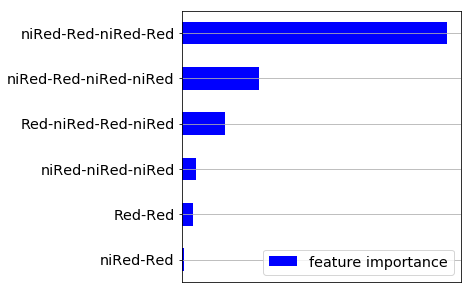

In [198]:
fig, ax = plt.subplots()
df.plot(kind='barh', color='blue', ax=ax, grid=True)
ax.legend(loc='lower right')
# ax.set_xlabel('amplitude')
plt.xticks([])
plt.savefig('pictures/feature_importance.png')
plt.show()

# Climatic dataset (3 years)

In [14]:
# targets_dico = pickle.load(open('crops/clim_labels.obj', 'rb'))
# y = list(targets_dico.values())

### 3-hourly 

In [15]:
# input1 = pickle.load(open('crops/clim_bags_1.obj', 'rb'))
# input2 = pickle.load(open('crops/clim_bags_2.obj', 'rb'))
# X = input1 + input2

###  daily averages

In [16]:
# X = pickle.load(open('crops/clim_summary_bags.obj', 'rb'))

**Cross validation type**

In [82]:
cv = temporal_CV(targets_dico)
#cv = spatial_CV(targets_dico)

In [83]:
reload(functionalities)

<module 'functionalities' from '/home/salvi/notebooks_new/functionalities.py'>

**Fit the models**

In [88]:
functionalities.RBF_RBF_SVM(X=X, y=y, ll=None, at=False, ss=False, cv=10)

Fitting 10 folds for each of 448 candidates, totalling 4480 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed: 56.0min
[Parallel(n_jobs=-1)]: Done 2338 tasks      | elapsed: 77.4min
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed: 101.2min
[Parallel(n_jobs=-1)]: Done 3938 tasks      | elapsed: 127.6min
[Parallel(n_jobs=-1)]: Done 4480 out of 4480 | elapsed: 144.3min finished


(0.609934121331111, 0.27306559838441796)

In [84]:
functionalities.ESig_SVM(2, X, y, ll=[0,1], at=True, ss=True, cv=10)

100%|██████████| 66/66 [00:16<00:00,  4.32it/s]

Fitting 10 folds for each of 180 candidates, totalling 1800 fits



[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:    1.9s finished


(0.3639715760290566, 0.12410949143248554)

In [85]:
functionalities.ESig_SVM(3, X, y, ll=[0,1], at=True, ss=True, cv=10)

100%|██████████| 66/66 [00:26<00:00,  2.91it/s]

Fitting 10 folds for each of 180 candidates, totalling 1800 fits



[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:    2.0s finished


(0.4810583077930605, 0.19209177657096965)

In [86]:
functionalities.ESig_SVM(4, X, y, ll=[0,1], at=True, ss=True, cv=10)

100%|██████████| 66/66 [01:26<00:00,  1.07s/it]

Fitting 10 folds for each of 180 candidates, totalling 1800 fits



[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:    2.5s finished


(0.5654169758125865, 0.2680345798639412)

In [87]:
functionalities.SigESig_LinReg(2, 2, X, y, ll=[0,1], at=True, ss=False, cv=10)

100%|██████████| 66/66 [01:13<00:00,  1.11it/s]

Fitting 10 folds for each of 32 candidates, totalling 320 fits



[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    5.1s finished


(0.4573613349240956, 0.2301600418424237)